# Plotting the CTH Results

In [1]:
%pylab inline
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.ticker as mtick
from hits import CyDetHits, CTHHits, CDCHits

## Import Data

In [3]:
# Test on signal or background data files
test_sig = True

In [4]:
file_base = "/home/elg112/ICEDUST_old/track_finding_standalone/"\
            "track_finding_yandex/data/"
cdc_sig_file = file_base + "after_sum_hit_cth.root"
cth_sig_file = cdc_sig_file

In [5]:
if test_sig:
    hits_cydet = CyDetHits(cdc_sig_file, 
                       tree="CDCHitTree",
                       branches=["MCPos.fP.fX", "MCPos.fP.fY","MCPos.fP.fZ"])
    hits_cth = CTHHits(cth_sig_file, 
                       tree="CTHHitTree",
                       branches=["MCPos.fP.fX","MCPos.fP.fY","MCPos.fP.fZ"])
else:
    hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])
    hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1], branches=["x", "y"])

In [6]:
hits = CDCHits(hits_cydet, hits_cth)

from cylinder import CyDet
geom = CyDet()
n_events = hits_cth.n_events
print "Start Events: {}".format(hits.cth.n_events)

Start Events: 4021


## Apply All Cuts

In [7]:
# Define cuts to use
n_hits_cut = False
layer_cut = False
timing_cut = False
use_cth_cut = True

In [8]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1100, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

In [9]:
hits.print_branches()

CTH Branches:
Branches available are:
CTHHit.fMCPos.fP.fX
CTHHit.fMCPos.fP.fY
CTHHit.fMCPos.fP.fZ
CTHHit.fIsSig
CTHHit.fEventNumber
CTHHit.fhits_index
CTHHit.fevent_index
CTHHit.fTrigTime
CTHHit.fvol_id
CTHHit.fCharge
CTHHit.fMCPos.fE
CyDet Branches:
Branches available are:
CDCHit.fMCPos.fP.fX
CDCHit.fMCPos.fP.fY
CDCHit.fMCPos.fP.fZ
CDCHit.fIsSig
CDCHit.fEventNumber
CDCHit.fhits_index
CDCHit.fevent_index
CDCHit.fTrigTime
CDCHit.fvol_id
CDCHit.fCharge
CDCHit.fDetectedTime


In [10]:
# Filter for CTH in time window.  Get the time
trigger_events = []
for evt in range(hits.n_events):
    sig_hits = hits.cth.get_signal_hits(evt)
    evt_index = np.unique(hits.cth.get_measurement(evt, "CTHHit.fEventNumber"))[0]
    if len(sig_hits) != 0:
        trigger_events.append(evt_index)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 3798


In [11]:
# Filter for max layer is five
max_layer = []
for evt in range(hits.n_events):
    these_layers = hits.cydet.geom.point_layers[hits.cydet.get_sig_wires(evt)]
    if len(hits.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "Number that pass layer cut: {}".format(len(good_max_layer))

Number that pass layer cut: 3303


In [12]:
# Filter for number of signal hits
n_signal_hits  = np.array([len(hits.cydet.get_signal_hits(evt)) 
                         for evt in range(hits.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits > 30)[0]
print "Number that pass n hits cut: {}".format(len(good_n_hits))

Number that pass n hits cut: 3480


In [13]:
# Apply quality and CTH cuts
print "Start Events: {}".format(hits.n_events)
if use_cth_cut:
    hits.trim_events(trigger_events)
    print "After CTH Trigger {}".format(hits.n_events)
if layer_cut:
    hits.trim_events(good_max_layer)
    print "After Layer Cut Trigger {}".format(hits.n_events)
if n_hits_cut:
    hits.trim_events(good_events)
    print "Afterb N Hits Cut Trigger {}".format(hits.n_events)

Start Events: 4021
After CTH Trigger 3798


In [14]:
print hits.cth.all_branches

['CTHHit.fMCPos.fP.fX', 'CTHHit.fMCPos.fP.fY', 'CTHHit.fMCPos.fP.fZ', 'CTHHit.fIsSig', 'CTHHit.fEventNumber', 'CTHHit.fhits_index', 'CTHHit.fevent_index', 'CTHHit.fTrigTime', 'CTHHit.fvol_id', 'CTHHit.fCharge', 'CTHHit.fMCPos.fE']


## Experiment to get the correct geometric parameters

In [15]:
vol_id_name = "CTHHit.fvol_id"
x_pos_name = "CTHHit.fMCPos.fP.fZ"
y_pos_name = "CTHHit.fMCPos.fP.fY"
hits.cth.up_data[x_pos_name] = hits.cth.up_data[x_pos_name]/10. - 765
hits.cth.up_data[y_pos_name] = hits.cth.up_data[y_pos_name]/10.
hits.cth.down_data[x_pos_name] = hits.cth.down_data[x_pos_name]/10. - 765
hits.cth.down_data[y_pos_name] = hits.cth.down_data[y_pos_name]/10.

AttributeError: 'CTHHits' object has no attribute 'up_data'

In [ ]:
from cylinder import CTH, CylindricalArray

In [ ]:
n_crystals = 64
# The first two rows are for the active volumes, third is for excluded
# volumes
cth_n_vols = [n_crystals, n_crystals, n_crystals]
cth_radii = [44.8, 48.3, 0.0]
cth_phi0 = [-np.pi/2. - np.pi/64, -np.pi/2. - np.pi/64, -np.pi/2. - np.pi/64]
test_geom = CylindricalArray(cth_n_vols, cth_radii, cth_phi0)

In [ ]:
widths = [1, 0.5]
heights = [9, 9]
deflection_angles = [-16.5, -10]
all_vols_shown = [range(64), range(64,128)]
print_me = False
evt = 1

### Plot the All CTH Hits From All Events

In [ ]:
vol_hits = hits.cth.filter_hits(hits.cth.down_data, vol_id_name, values=range(128))
plt.scatter(vol_hits[x_pos_name], vol_hits[y_pos_name], s=1, transform=gca().transData._b)    

In [ ]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volumev
vol_hits = hits.cth.filter_hits(hits.cth.down_data, vol_id_name, values=range(128))
plt.scatter(vol_hits[x_pos_name], vol_hits[y_pos_name], s=1, transform=gca().transData._b)    

### Ensure Drawn Volumes Overlap With Hits

In [ ]:
for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):
    for vol in vols_shown[:3]: 
        x = -test_geom.point_x[vol]
        y = -test_geom.point_y[vol]
        print x, y
        
        theta_rotate = np.arctan((-y)/(x)) - deflection*np.pi/180.
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        print x_plt, y_plt, wid, hgt
        this_vol = hits.cth.filter_hits(vol_hits, vol_id_name, values=vol)

        plt.scatter(this_vol[x_pos_name], this_vol[y_pos_name], s=1, transform=gca().transData._b)
        plot_angle = (theta_rotate/np.pi) * 180.
        plot_rect = plt.Rectangle((x_plt, y_plt), wid*100, hgt*100,\
                                    color="red", fill=True)
        gca().add_artist(plot_rect)
        plt.show()

### Draw Volumes over Hits

In [ ]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volumev
vol_hits = hits.cth.filter_hits(hits.cth.down_data, vol_id_name, values=range(128)[::5])
plt.scatter(vol_hits[x_pos_name], vol_hits[y_pos_name], s=1, transform=gca().transData._b)    

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 

        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, vol_id_name, values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol[x_pos_name]) - min(this_vol[x_pos_name]))
            #y_true = (max(this_vol[y_pos_name]) - min(this_vol[y_pos_name]))
            # Average
            x_true = average(this_vol[x_pos_name])
            y_true = average(this_vol[y_pos_name])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.

        plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                  transform=gca().transData._b, fill=False, color="red")
           #     color="green", fill=False, alpha=l_alpha, lw=lw)
        gca().add_artist(plot_rect)

### Draw Volumes with no Hits

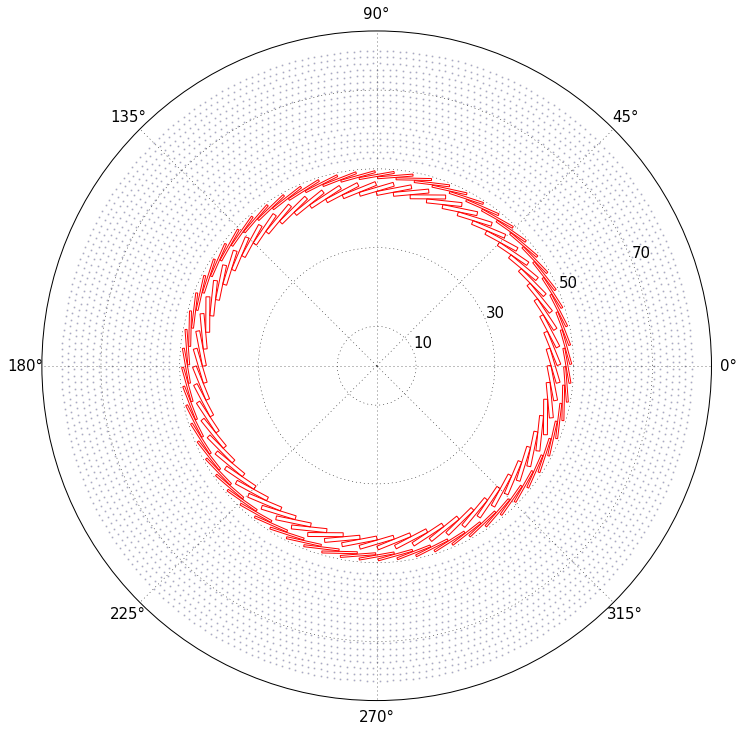

In [23]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(np.zeros(hits.cydet.geom.n_points), geom)
cth_hits = hits.cth.get_hit_vols(evt)

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 

        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, vol_id_name, values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol[x_pos_name]) - min(this_vol[x_pos_name]))
            #y_true = (max(this_vol[y_pos_name]) - min(this_vol[y_pos_name]))
            # Average
            x_true = average(this_vol[x_pos_name])
            y_true = average(this_vol[y_pos_name])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.

        plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                  transform=gca().transData._b, fill=False, color="red")
           #     color="green", fill=False, alpha=l_alpha, lw=lw)
        gca().add_artist(plot_rect)

## Drawing the Hit Volumes

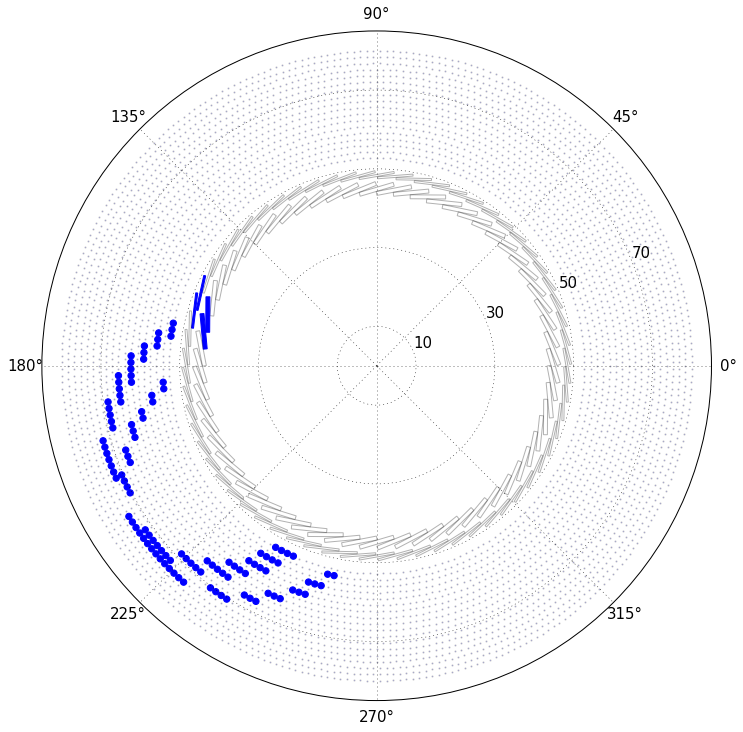

In [24]:
all_hits = hits.cydet.get_hit_types(evt)
plot_output(all_hits, geom)
cth_hits = hits.cth.get_hit_vols(evt)

# Get all hit points in first volume
sig_vols_shown = hits.cth.get_sig_vols(events=evt)
bkg_vols_shown = hits.cth.get_bkg_vols(events=evt)

for wid, hgt, deflection, vols_shown in zip(widths, heights, deflection_angles, all_vols_shown):

    for vol, x, y in zip(vols_shown, test_geom.point_x[vols_shown],test_geom.point_y[vols_shown]): 
        theta_rotate = np.arctan((y)/(x)) - deflection*np.pi/180
        x_plt = x + sin(theta_rotate)*hgt/2. - cos(theta_rotate)*wid/2.
        y_plt = y - cos(theta_rotate)*hgt/2. - sin(theta_rotate)*wid/2.

        # Truth information
        this_vol = hits.cth.filter_hits(vol_hits, vol_id_name, values=vol)

        if print_me:
            # Range
            #x_true = (max(this_vol[x_pos_name]) - min(this_vol[x_pos_name]))
            #y_true = (max(this_vol[y_pos_name]) - min(this_vol[y_pos_name]))
            # Average
            x_true = average(this_vol[x_pos_name])
            y_true = average(this_vol[y_pos_name])
            print "index " + str(vol)
            print "  x " + str(test_geom.point_x[vol])
            #print "  x_plt " + str(x_plt)
            print "  x_true " + str(x_true)
            print "  y " + str(test_geom.point_y[vol])
            #print "  y_plt " + str(y_plt)
            print "  y_true " + str(y_true)
            print y_true - y 
            print x_true - x
            print sqrt(x_true**2 + y_true**2)

        plot_angle = (theta_rotate/np.pi) * 180.
        if vol in sig_vols_shown:
            plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                      transform=gca().transData._b, color="blue")
        elif vol in bkg_vols_shown:
            plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                      transform=gca().transData._b, color="red")
            #     color="green", fill=False, alpha=l_alpha, lw=lw)
        else: 
            plot_rect = plt.Rectangle((x_plt, y_plt), wid, hgt, angle=plot_angle,\
                                      transform=gca().transData._b, fill=False, lw=1, alpha=0.3,
                                      color="black")
        gca().add_artist(plot_rect)  